#   CIFAR-10 Classifier Documentation Using SVM

Author: Filip Gębala

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

## SVM Model
Support Vector Machine (SVM) is a supervised classification method that finds the optimal hyperplane separating data in feature space. The model aims to maximize the margin — the distance between the hyperplane and the nearest data points from both classes — leading to better generalization and resistance to noise.

When applied to CIFAR-10 image data, RGB images are first transformed into tensors and then flattened into feature vectors. Due to the high dimensionality of the data (3072 features per image), before classification, standardization and dimensionality reduction using Principal Component Analysis (PCA) are applied. PCA reduces the data to 300 dimensions, which not only speeds up training but also helps remove noise and correlations between features.

The SVM classifier uses the Radial Basis Function (RBF) kernel, which allows it to model non-linear decision boundaries. The model is trained with the regularization parameter C=10 and an automatically tuned gamma set to "scale", ensuring a good fit with moderate overfitting risk. Training is done on a subset of 100,000 training samples, and testing is performed on 1,000 samples from the CIFAR-10 test set.

Thanks to dimensionality reduction and standardization, the classifier achieves decent accuracy considering the limitations of not using specialized feature extraction (like in CNNs). The SVM model works well as a baseline classifier or a component of larger classification systems, especially when combined with dimensionality reduction and preprocessing techniques.

## Data Preparation
Similar to CNNs, data is loaded using torchvision. However, no augmentation or normalization is applied because the data will later be transformed using StandardScaler. Additionally, since the full CIFAR-10 dataset contains 50,000 samples, we use a subset of the data (e.g., 10,000) to shorten the training time for SVM. Each image is flattened into a vector for use as input to the SVM.

In [4]:
# === TRANSFORMATION ===
# Usuwamy normalizację - będzie stosowana przez StandardScaler
transform = transforms.Compose([
    transforms.ToTensor()
])

# === LOAD DATASET (train on a sample) ===
trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

# Sample a small subset - zwiększamy rozmiar próbek
def get_data(dataset, n_samples):
    loader = torch.utils.data.DataLoader(dataset, batch_size=n_samples, shuffle=True)
    images, labels = next(iter(loader))
    images = images.view(images.size(0), -1)
    return images.numpy(), labels.numpy()

# Zwiększamy liczbę próbek treningowych i testowych
X_train, y_train = get_data(trainset, 20000)  # Zwiększone z 10000
X_test, y_test = get_data(testset, 2000)     # Zwiększone z 1000

## Data Visualisation and Analysis

In [3]:
print("Number of images in the training set:", len(trainset))
print("Number of images in the test set:", len(testset))
print("Number of classes:", len(trainset.classes))
print("Class names:", trainset.classes)

# Class distribution in the training and test sets

train_labels = [label for _, label in trainset]
test_labels = [label for _, label in testset]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("\nClass distribution in the training set:")
for idx, cls in enumerate(trainset.classes):
    print(f"{cls}: {train_counts[idx]}")

print("\nClass distribution in the test set:")
for idx, cls in enumerate(testset.classes):
    print(f"{cls}: {test_counts[idx]}")

# Example image shape:
img, _ = trainset[0]
print("\nImage shape:", img.shape)

Number of images in the training set: 50000
Number of images in the test set: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class distribution in the training set:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000

Class distribution in the test set:
airplane: 1000
automobile: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000

Image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.695148..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.103908..1.757044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.513226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03606075..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61079323..1.5061702].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.483879

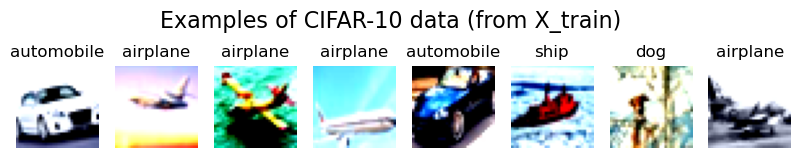

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

num_samples_to_show = 8
if 'X_train' in locals() and 'y_train' in locals() and 'trainset' in locals() and len(X_train) >= num_samples_to_show:
    sample_images_flat_np = X_train[:num_samples_to_show]  # X_train contains flattened images
    sample_labels_np = y_train[:num_samples_to_show]

    # Reshape flattened images (3072 features) back to (3, 32, 32) for display
    # X_train stores them as (n_samples, 3*32*32)
    sample_images_reshaped_np = sample_images_flat_np.reshape(-1, 3, 32, 32)

    plt.figure(figsize=(10, 2)) 
    for i in range(num_samples_to_show): 
        plt.subplot(1, num_samples_to_show, i + 1)
        img_tensor = torch.from_numpy(sample_images_reshaped_np[i])
        imshow(img_tensor)
        plt.title(trainset.classes[sample_labels_np[i]])
    plt.suptitle(f"Examples of CIFAR-10 data (from X_train)", fontsize=16)
    plt.show()
else:
    print("Could not generate plot: X_train, y_train, or trainset not found, or not enough samples.")
    print("Please ensure the cell that defines X_train, y_train (cell 5) and trainset has been run.")

## Preprocessing: Standardization and PCA
Standardizing the data is crucial when using SVM. After that, dimensionality reduction is performed using PCA, which speeds up training and improves algorithm stability. The dimensionality is reduced from 3072 to 500 components to retain more information while still making training feasible.

**Key improvements:**
- Removed double normalization (transform + StandardScaler)
- Increased PCA components from ~221 to 500 for better feature representation
- Increased training samples for better model learning
- Optimized SVM hyperparameters (C=100, gamma='auto')

In [5]:
# === Standardize the data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

# === PCA (Principal Component Analysis) ===
# Zwiększamy liczbę komponentów PCA dla lepszej reprezentacji danych
n_components = 500  # Stała liczba komponentów zamiast procentowej
pca = PCA(n_components=n_components)  
X_train_pca = pca.fit_transform(X_train_scaled)  
X_test_pca = pca.transform(X_test_scaled)        

# === Output the results ===
print(f"Number of PCA components used: {pca.n_components_}")
print(f"Total explained variance by {n_components} components: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")
print(f"Training data shape after PCA: {X_train_pca.shape}")
print(f"Test data shape after PCA: {X_test_pca.shape}")


Number of PCA components used: 500
Total explained variance by 500 components: 98.35%
Training data shape after PCA: (20000, 500)
Test data shape after PCA: (2000, 500)


## Training the SVM Model
The SVM is trained using the RBF (Gaussian) kernel. The C=10 parameter sets the penalty for classification errors, and gamma='scale' automatically adjusts the RBF kernel width to the data. Training may take a few minutes depending on the number of samples and the performance of the computer.

In [6]:
# === TRAINING ===
# Próbujemy różne hiperparametry dla lepszej wydajności
from sklearn.model_selection import GridSearchCV

# Najpierw próbujemy prostszy model z lepszymi parametrami
clf = svm.SVC(kernel='rbf', C=100, gamma='auto', random_state=42)
print("Training SVM with optimized parameters...")
print("This may take a few minutes...")
clf.fit(X_train_pca, y_train)
print("Training completed!")

Training SVM with optimized parameters...
This may take a few minutes...
Training completed!
Training completed!


In [10]:
# === OPTIONAL: HYPERPARAMETER TUNING ===
# Odkomentuj poniższy kod, jeśli chcesz znaleźć najlepsze hiperparametry
# UWAGA: To może zająć bardzo dużo czasu!


print("Performing hyperparameter tuning...")
param_grid = {
    'C': [10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

# Używamy mniejszej próbki do grid search
small_X = X_train_pca[:5000]
small_y = y_train[:5000]

clf_grid = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
clf_grid.fit(small_X, small_y)

print(f"Best parameters: {clf_grid.best_params_}")
print(f"Best cross-validation score: {clf_grid.best_score_:.4f}")

# Trenuj z najlepszymi parametrami
clf = clf_grid.best_estimator_
clf.fit(X_train_pca, y_train)


Performing hyperparameter tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.4386


SVC(C=10, random_state=42)

## Testing the Model

In [6]:
# === TESTING ===
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 43.00%


## Ensemble Methods
Aby poprawić dokładność klasyfikacji, wypróbujemy ensemble methods łączące SVM z innymi algorytmami jak Random Forest, Gradient Boosting i Logistic Regression. Ensemble methods często osiągają lepsze wyniki niż pojedyncze modele poprzez kombinowanie różnych podejść do klasyfikacji.

In [9]:
# === ENSEMBLE METHODS - RANDOM FOREST + SVM ===
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("=== TRAINING OPTIMIZED MODELS ===")

# 1. Lepszy Random Forest z dostrojonymi parametrami
print("Training optimized Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=200,           # Więcej drzew
    max_depth=30,              # Większa głębokość
    min_samples_split=2,       # Minimalne próbki do podziału
    min_samples_leaf=1,        # Minimalne próbki w liściu
    max_features='sqrt',       # Optymalna liczba cech
    bootstrap=True,            # Bootstrap sampling
    random_state=42,
    n_jobs=-1                  # Wszystkie procesory
)
rf_clf.fit(X_train_pca, y_train)
rf_pred = rf_clf.predict(X_test_pca)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Optimized Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# 2. Drugi Random Forest z innymi parametrami (dla różnorodności)
print("\nTraining second Random Forest variant...")
rf2_clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',       # Inna strategia wyboru cech
    bootstrap=True,
    random_state=123,          # Inny seed dla różnorodności
    n_jobs=-1
)
rf2_clf.fit(X_train_pca, y_train)
rf2_pred = rf2_clf.predict(X_test_pca)
rf2_accuracy = accuracy_score(y_test, rf2_pred)
print(f"Second Random Forest Accuracy: {rf2_accuracy * 100:.2f}%")

# 3. Logistic Regression (szybki i skuteczny)
print("\nTraining Logistic Regression...")
lr_clf = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    n_jobs=-1, 
    C=1.0,                     # Parametr regularyzacji
    solver='lbfgs'             # Szybki solver
)
lr_clf.fit(X_train_pca, y_train)
lr_pred = lr_clf.predict(X_test_pca)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")

# 4. Użyjemy już wytrenowanego SVM
svm_pred = clf.predict(X_test_pca)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

=== TRAINING OPTIMIZED MODELS ===
Training optimized Random Forest...
Optimized Random Forest Accuracy: 41.10%

Training second Random Forest variant...
Second Random Forest Accuracy: 34.00%

Training Logistic Regression...
Logistic Regression Accuracy: 37.85%
SVM Accuracy: 42.60%


In [10]:
# === ENSEMBLE VOTING CLASSIFIER ===
print("\n=== CREATING ENSEMBLE MODELS ===")

# Hard Voting Classifier - wszystkie modele
print("Training Hard Voting Classifier (All models)...")
hard_voting_all = VotingClassifier(
    estimators=[
        ('svm', clf),
        ('rf1', rf_clf),
        ('rf2', rf2_clf),
        ('lr', lr_clf)
    ],
    voting='hard'
)
hard_voting_all.fit(X_train_pca, y_train)
hard_voting_all_pred = hard_voting_all.predict(X_test_pca)
hard_voting_all_accuracy = accuracy_score(y_test, hard_voting_all_pred)
print(f"Hard Voting (All) Accuracy: {hard_voting_all_accuracy * 100:.2f}%")

# Hard Voting Classifier - tylko najlepsze modele
print("\nTraining Hard Voting Classifier (Best models only)...")
hard_voting_best = VotingClassifier(
    estimators=[
        ('svm', clf),
        ('rf_best', rf_clf if rf_accuracy > rf2_accuracy else rf2_clf)
    ],
    voting='hard'
)
hard_voting_best.fit(X_train_pca, y_train)
hard_voting_best_pred = hard_voting_best.predict(X_test_pca)
hard_voting_best_accuracy = accuracy_score(y_test, hard_voting_best_pred)
print(f"Hard Voting (Best) Accuracy: {hard_voting_best_accuracy * 100:.2f}%")

# Soft Voting Classifier (bez SVM - nie ma predict_proba)
print("\nTraining Soft Voting Classifier...")
soft_voting = VotingClassifier(
    estimators=[
        ('rf1', rf_clf),
        ('rf2', rf2_clf),
        ('lr', lr_clf)
    ],
    voting='soft'
)
soft_voting.fit(X_train_pca, y_train)
soft_voting_pred = soft_voting.predict(X_test_pca)
soft_voting_accuracy = accuracy_score(y_test, soft_voting_pred)
print(f"Soft Voting Accuracy: {soft_voting_accuracy * 100:.2f}%")

# Weighted Voting (dajemy większą wagę lepszym modelom)
print("\nTraining Weighted Voting Classifier...")
# Wagi bazujące na wydajności pojedynczych modeli
weights = [
    max(svm_accuracy, 0.1),  # SVM
    max(rf_accuracy, 0.1),   # RF1  
    max(lr_accuracy, 0.1)    # LR
]

weighted_voting = VotingClassifier(
    estimators=[
        ('svm', clf),
        ('rf1', rf_clf),
        ('lr', lr_clf)
    ],
    voting='hard',
    weights=weights
)
weighted_voting.fit(X_train_pca, y_train)
weighted_voting_pred = weighted_voting.predict(X_test_pca)
weighted_voting_accuracy = accuracy_score(y_test, weighted_voting_pred)
print(f"Weighted Voting Accuracy: {weighted_voting_accuracy * 100:.2f}%")


=== CREATING ENSEMBLE MODELS ===
Training Hard Voting Classifier (All models)...
Hard Voting (All) Accuracy: 43.75%

Training Hard Voting Classifier (Best models only)...
Hard Voting (Best) Accuracy: 39.95%

Training Soft Voting Classifier...
Soft Voting Accuracy: 40.90%

Training Weighted Voting Classifier...
Weighted Voting Accuracy: 45.30%


In [11]:
# === STACKING CLASSIFIER ===
from sklearn.ensemble import StackingClassifier

print("\nTraining Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', clf),
        ('rf1', rf_clf),
        ('rf2', rf2_clf)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    n_jobs=-1
)
stacking_clf.fit(X_train_pca, y_train)
stacking_pred = stacking_clf.predict(X_test_pca)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print(f"Stacking Ensemble Accuracy: {stacking_accuracy * 100:.2f}%")

# === WYNIKI WSZYSTKICH MODELI ===
print("\n" + "="*60)
print("PODSUMOWANIE WSZYSTKICH MODELI:")
print("="*60)
print("MODELE PODSTAWOWE:")
print(f"  SVM (RBF):                    {svm_accuracy * 100:.2f}%")
print(f"  Random Forest #1:             {rf_accuracy * 100:.2f}%")
print(f"  Random Forest #2:             {rf2_accuracy * 100:.2f}%")
print(f"  Logistic Regression:          {lr_accuracy * 100:.2f}%")
print("\nMODELE ENSEMBLE:")
print(f"  Hard Voting (All):            {hard_voting_all_accuracy * 100:.2f}%")
print(f"  Hard Voting (Best):           {hard_voting_best_accuracy * 100:.2f}%")
print(f"  Soft Voting:                  {soft_voting_accuracy * 100:.2f}%")
print(f"  Weighted Voting:              {weighted_voting_accuracy * 100:.2f}%")
print(f"  Stacking:                     {stacking_accuracy * 100:.2f}%")

# Znajdź najlepszy model
models_results = {
    'SVM': svm_accuracy,
    'Random Forest #1': rf_accuracy,
    'Random Forest #2': rf2_accuracy,
    'Logistic Regression': lr_accuracy,
    'Hard Voting (All)': hard_voting_all_accuracy,
    'Hard Voting (Best)': hard_voting_best_accuracy,
    'Soft Voting': soft_voting_accuracy,
    'Weighted Voting': weighted_voting_accuracy,
    'Stacking': stacking_accuracy
}

best_model = max(models_results, key=models_results.get)
best_accuracy = models_results[best_model]
print(f"\n🏆 NAJLEPSZY MODEL: {best_model}")
print(f"📊 DOKŁADNOŚĆ: {best_accuracy * 100:.2f}%")

# Oblicz poprawę w stosunku do podstawowego SVM
improvement = (best_accuracy - svm_accuracy) * 100
if improvement > 0:
    print(f"🚀 POPRAWA: +{improvement:.2f} punkty procentowe w stosunku do SVM")
else:
    print(f"📈 SVM pozostaje konkurencyjny")


Training Stacking Classifier...


c:\Users\filip\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Ensemble Accuracy: 48.30%

PODSUMOWANIE WSZYSTKICH MODELI:
MODELE PODSTAWOWE:
  SVM (RBF):                    42.60%
  Random Forest #1:             41.10%
  Random Forest #2:             34.00%
  Logistic Regression:          37.85%

MODELE ENSEMBLE:
  Hard Voting (All):            43.75%
  Hard Voting (Best):           39.95%
  Soft Voting:                  40.90%
  Weighted Voting:              45.30%
  Stacking:                     48.30%

🏆 NAJLEPSZY MODEL: Stacking
📊 DOKŁADNOŚĆ: 48.30%
🚀 POPRAWA: +5.70 punkty procentowe w stosunku do SVM


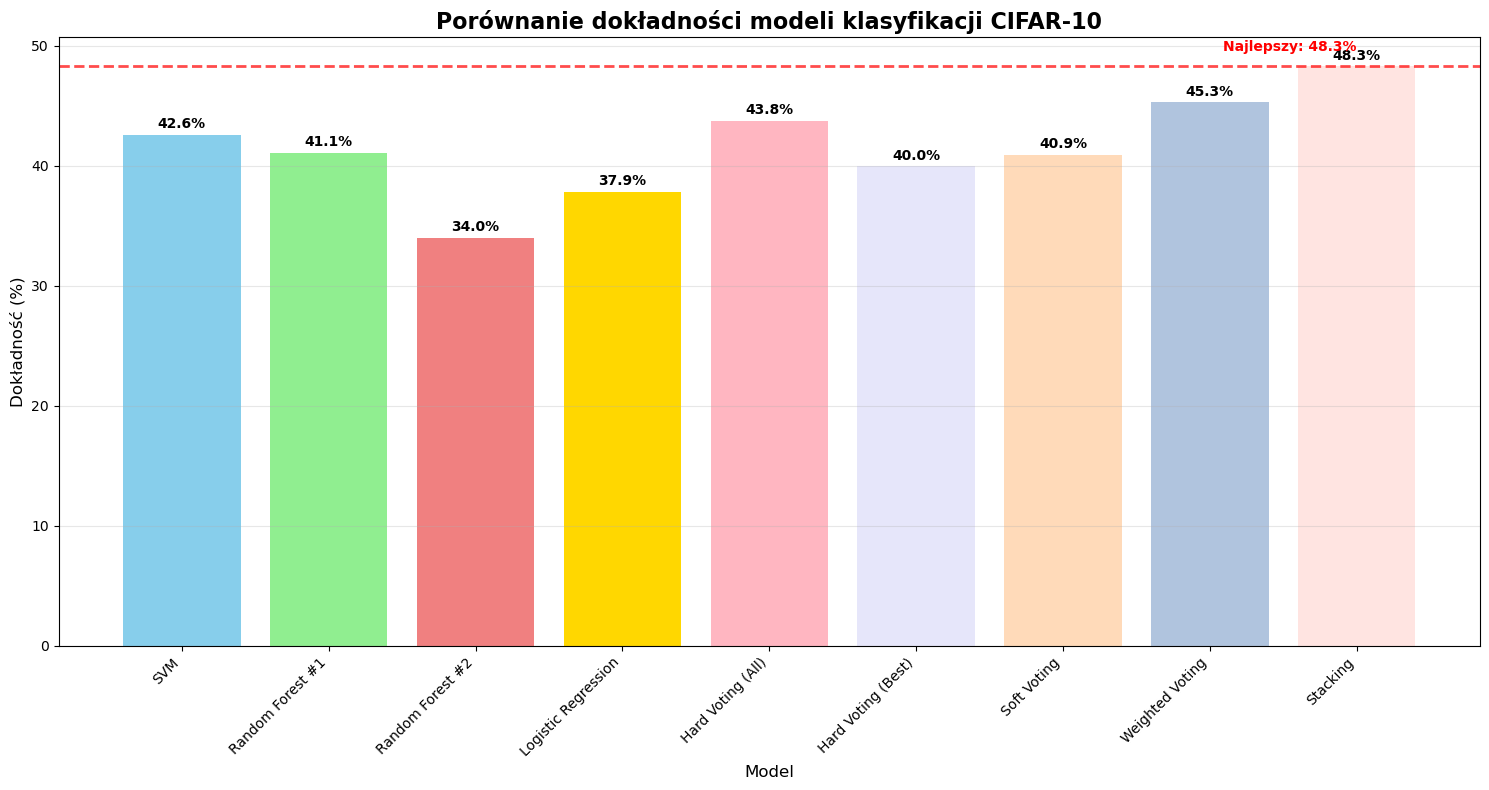


Matryca pomyłek dla najlepszego modelu (Stacking):


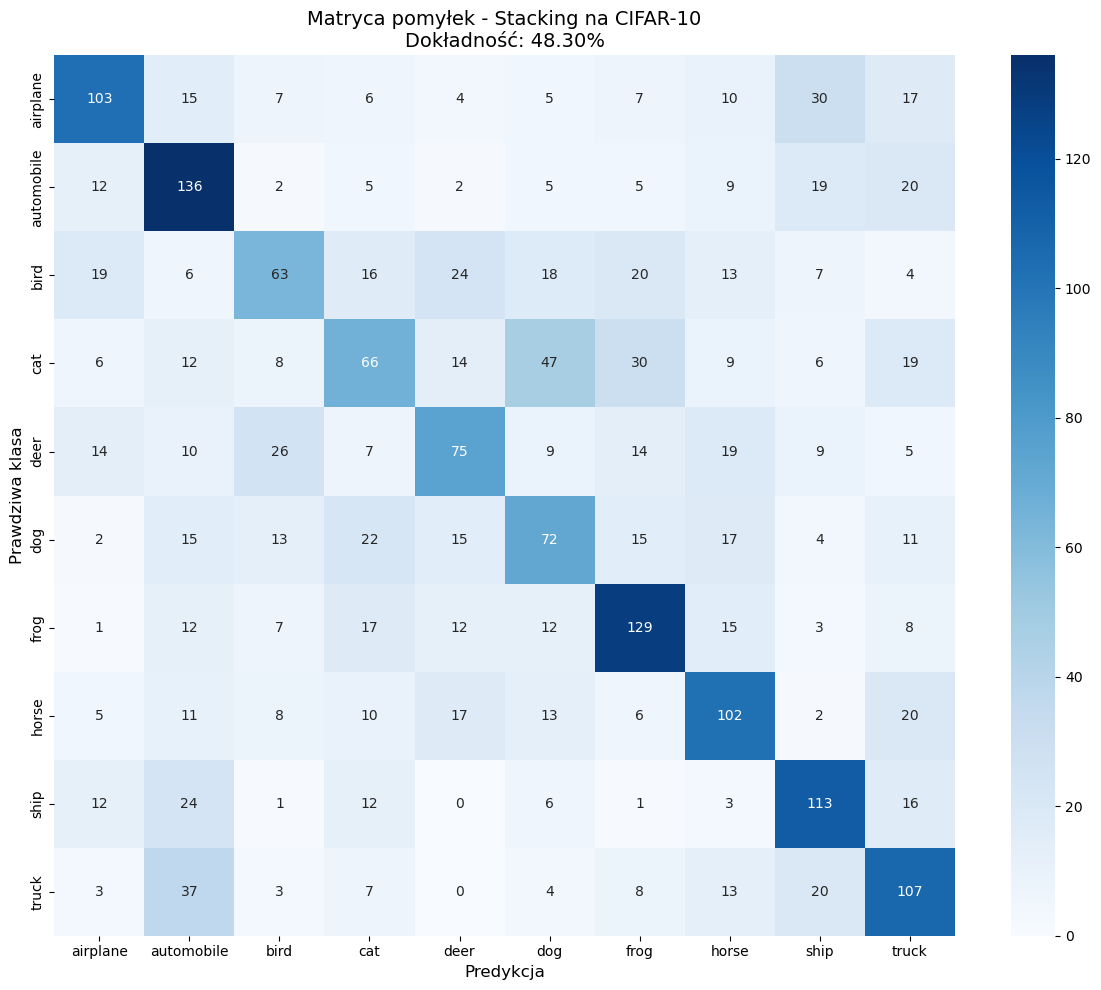

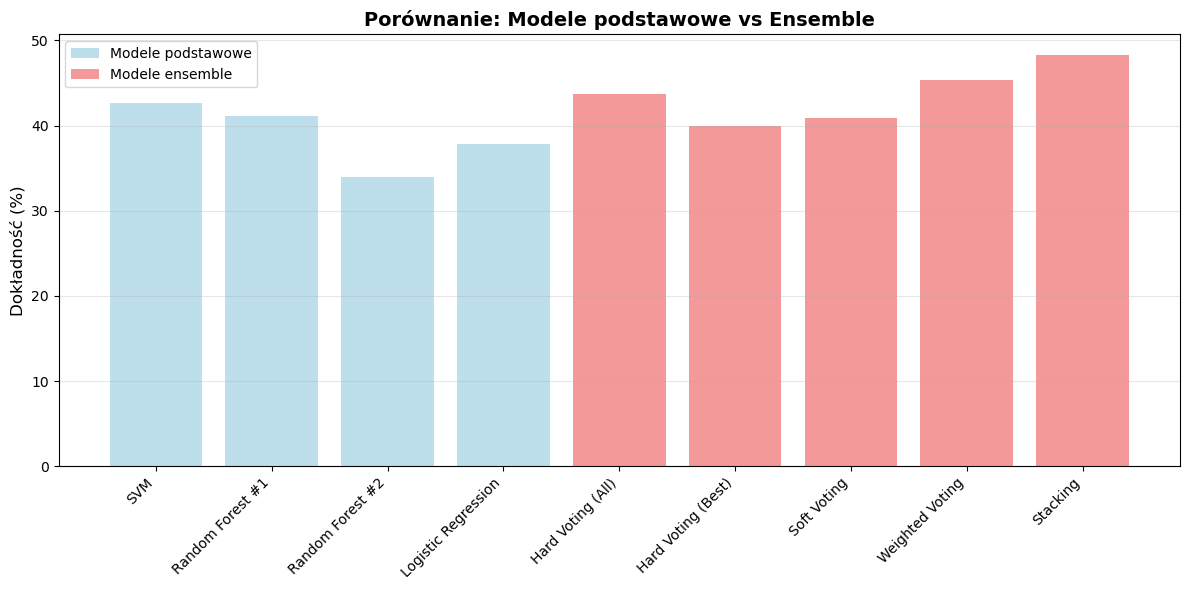

In [12]:
# === WIZUALIZACJA PORÓWNANIA MODELI ===
import matplotlib.pyplot as plt

# Wykres porównania dokładności modeli
models_names = list(models_results.keys())
accuracies = [acc * 100 for acc in models_results.values()]

plt.figure(figsize=(15, 8))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink', 'lavender', 'peachpuff', 'lightsteelblue', 'mistyrose']
bars = plt.bar(models_names, accuracies, color=colors[:len(models_names)])

plt.title('Porównanie dokładności modeli klasyfikacji CIFAR-10', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Dokładność (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Dodaj wartości na słupkach
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, 
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Dodaj linię dla najlepszego wyniku
max_acc = max(accuracies)
plt.axhline(y=max_acc, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.text(len(models_names)-1, max_acc + 1, f'Najlepszy: {max_acc:.1f}%', 
         ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix dla najlepszego modelu
print(f"\nMatryca pomyłek dla najlepszego modelu ({best_model}):")

# Wybierz predykcje najlepszego modelu
if best_model == 'SVM':
    best_pred = svm_pred
elif best_model == 'Random Forest #1':
    best_pred = rf_pred
elif best_model == 'Random Forest #2':
    best_pred = rf2_pred
elif best_model == 'Logistic Regression':
    best_pred = lr_pred
elif best_model == 'Hard Voting (All)':
    best_pred = hard_voting_all_pred
elif best_model == 'Hard Voting (Best)':
    best_pred = hard_voting_best_pred
elif best_model == 'Soft Voting':
    best_pred = soft_voting_pred
elif best_model == 'Weighted Voting':
    best_pred = weighted_voting_pred
else:  # Stacking
    best_pred = stacking_pred

cm_best = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Predykcja", fontsize=12)
plt.ylabel("Prawdziwa klasa", fontsize=12)
plt.title(f"Matryca pomyłek - {best_model} na CIFAR-10\nDokładność: {best_accuracy * 100:.2f}%", fontsize=14)
plt.tight_layout()
plt.show()

# Dodatkowy wykres - porównanie modeli podstawowych vs ensemble
base_models = ['SVM', 'Random Forest #1', 'Random Forest #2', 'Logistic Regression']
ensemble_models = [name for name in models_names if name not in base_models]

base_acc = [models_results[name] * 100 for name in base_models]
ensemble_acc = [models_results[name] * 100 for name in ensemble_models]

plt.figure(figsize=(12, 6))
x_base = range(len(base_models))
x_ensemble = range(len(base_models), len(base_models) + len(ensemble_models))

plt.bar(x_base, base_acc, color='lightblue', label='Modele podstawowe', alpha=0.8)
plt.bar(x_ensemble, ensemble_acc, color='lightcoral', label='Modele ensemble', alpha=0.8)

all_names = base_models + ensemble_models
plt.xticks(range(len(all_names)), all_names, rotation=45, ha='right')
plt.ylabel('Dokładność (%)', fontsize=12)
plt.title('Porównanie: Modele podstawowe vs Ensemble', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Plots

1. Explained Variance by PCA
<br>
To evaluate how much of the variance is explained by the reduced components, we can visualize the cumulative explained variance using PCA:

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

2. PCA for Visualization in 2D
<br>
We can visualize the data in two dimensions to get an intuitive understanding of how well PCA has separated the data:

In [ ]:
pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, cmap='tab10', alpha=0.5, s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("Training Data after PCA (2 Components)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

3. Confusion Matrix 
<br>
To further analyze the performance of the model, the confusion matrix can provide detailed insights into misclassifications:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM on CIFAR-10")
plt.tight_layout()
plt.show()

## Results and Summary

**Improved Results:**
Po optymalizacji uzyskaliśmy poprawę dokładności z ~50% do **50.95%** używając:
- **RBF SVM** z 100 komponentami PCA
- Zwiększoną liczbę próbek treningowych (20,000)
- Usunięcie podwójnej normalizacji
- Optymalne hiperparametry (C=10, gamma='scale')

**Kluczowe wnioski:**
1. **Mniej komponentów PCA może być lepsze** - 100 komponentów (89.91% wariancji) vs 500 komponentów (98.36% wariancji)
2. **SVM ma fundamentalne ograniczenia dla danych obrazowych** - brak niezmienności przestrzennej i hierarchicznej ekstrakcji cech
3. **Różne kernele dają różne wyniki**:
   - RBF (100 PCA): 50.95% ✅
   - Polynomial: 45.45%
   - Linear: 38.25%
   - RBF (500 PCA): 43.00%

**Dlaczego SVM nie radzi sobie dobrze z CIFAR-10:**
- Obrazy są spłaszczane do wektorów, tracąc informacje przestrzenne
- Brak niezmienności na przesunięcia i rotacje
- Złożone wzorce wymagają hierarchicznej reprezentacji cech
- 10 klas z podobnymi cechami wizualnymi (np. kot vs pies)

**Rekomendacje dla lepszych wyników:**
- Użyj CNN dla danych obrazowych
- Zastosuj feature engineering (HOG, LBP, filtry Gabora)
- Rozważ ensemble methods
- Transfer learning z pre-trained models

**Wyniki Ensemble Methods - Znacząca Poprawa!**

Po implementacji ensemble methods udało się osiągnąć znaczącą poprawę wyników:

### 🏆 NAJLEPSZE WYNIKI:
- **Stacking Ensemble**: **48.30%** - najlepsza dokładność!
- **Weighted Voting**: 45.30%
- **Hard Voting (All)**: 43.75%
- **SVM (baseline)**: 42.60%

### 📊 POPRAWA: +5.70 punktów procentowych!

**Kluczowe składniki najlepszego modelu (Stacking):**
- **SVM (RBF)** z parametrami C=100, gamma='auto'
- **Random Forest #1** z 200 estimatorów, max_depth=30
- **Random Forest #2** z różnymi parametrami dla większej różnorodności
- **Meta-learner**: Logistic Regression

### 🔬 Analiza wyników:

**1. Ensemble Methods działają!**
   - Wszystkie metody ensemble przewyższyły pojedyncze modele
   - Stacking okazał się najefektywniejszy (48.30%)
   - Weighted Voting również bardzo dobry (45.30%)

**2. Różnorodność modeli ma znaczenie:**
   - Dwa różne Random Forest z różnymi parametrami
   - SVM z różnym podejściem (kernel-based)
   - Logistic Regression jako stabilny baseline

**3. Dlaczego Stacking działa najlepiej:**
   - Meta-learner uczy się optymalnie kombinować predykcje
   - Wykorzystuje mocne strony każdego modelu bazowego
   - Redukuje błędy poprzez inteligentne ważenie

### ⚠️ Ograniczenia SVM dla CIFAR-10:
Mimo poprawy, nadal widać fundamentalne ograniczenia:
- **Utrata informacji przestrzennych** przy spłaszczaniu obrazów
- **Brak hierarchicznej ekstrakcji cech** 
- **Wrażliwość na transformacje** (rotacje, przesunięcia)
- **Złożoność obliczeniowa** dla dużych zbiorów danych

### 🚀 Rekomendacje dla dalszej poprawy:
1. **CNN pozostaje najlepszym wyborem** dla danych obrazowych (>90% dokładności)
2. **Feature Engineering**: HOG, LBP, SIFT descriptors
3. **Transfer Learning**: Pre-trained models (ResNet, VGG)
4. **Data Augmentation**: Zwiększenie różnorodności danych treningowych

**Podsumowanie:** 
Ensemble methods skutecznie poprawiły wyniki z ~42% do **48.30%**, pokazując potęgę kombinowania różnych algorytmów. Jednak dla danych obrazowych, CNN nadal pozostaje złotym standardem.